In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
image_dir = '/content/drive/My Drive/cavallo'

images = []
for filename in os.listdir(image_dir):
    image_path = os.path.join(image_dir, filename)
    image = cv2.imread(image_path)

    if image is not None:
        image = cv2.resize(image, (120, 120))
        images.append(image)

print("Number of images read:", len(images))

Number of images read: 2623


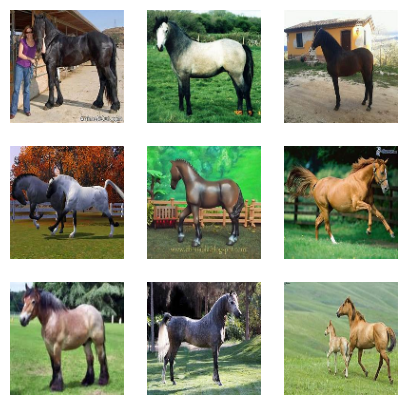

In [4]:
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.show()

In [5]:
def divide_image(image):
    parts = []
    height, width, _ = image.shape
    part_height = height // 3
    part_width = width // 3

    for i in range(3):
        for j in range(3):
            part = image[i*part_height:(i+1)*part_height, j*part_width:(j+1)*part_width]
            parts.append(part)

    return parts

In [6]:
def generate_combinations(parts, num_combinations):
    combinations = []
    original_positions = []
    indices = list(range(len(parts)))

    for _ in range(num_combinations):
        random.shuffle(indices)
        combination = [parts[i] for i in indices]
        combinations.append(combination)
        original_positions.append(indices.copy())

    return combinations, original_positions

In [7]:
def stitch_shuffled_image(parts):
    num_parts = len(parts)
    part_size = parts[0].shape[0]  # Assuming all parts are square

    stitched_image_size = int(np.sqrt(num_parts) * part_size)
    stitched_image = np.zeros((stitched_image_size, stitched_image_size, parts[0].shape[2]), dtype=np.uint8)

    for i in range(stitched_image.shape[0] // part_size):
        for j in range(stitched_image.shape[1] // part_size):
            part_index = i * int(stitched_image.shape[0] / part_size) + j
            stitched_image[i*part_size:(i+1)*part_size, j*part_size:(j+1)*part_size] = parts[part_index]

    return stitched_image

In [8]:
input_data = []
target_data = []
non_converted_target_data = []

for image in images:
    parts = divide_image(image)
    combinations, original_positions = generate_combinations(parts, 10)

    for idx, combination in enumerate(combinations):
        shuffled_image = stitch_shuffled_image(combination)
        input_data.append(shuffled_image)

        dummy_target = np.zeros((9, 9), dtype=np.uint8)
        for i in range(9):
            dummy_target[i, original_positions[idx][i]] = 1

        target_data.append(dummy_target.flatten())
        non_converted_target_data.append(original_positions[idx])

In [9]:
input_data = np.array(input_data)
target_data = np.array(target_data)

print("Input data shape:", input_data.shape)
print("Target data shape:", target_data.shape)

Input data shape: (26230, 120, 120, 3)
Target data shape: (26230, 81)


target
[[0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0]]
non_converted_target [7, 5, 6, 3, 1, 8, 2, 0, 4]


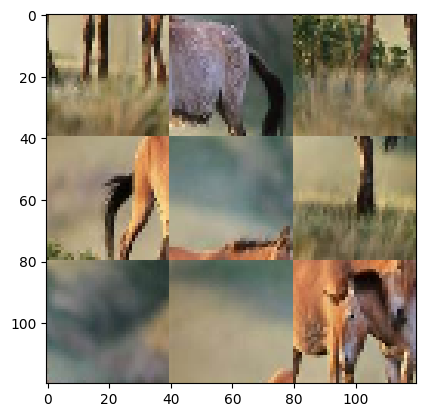

In [10]:
idx = random.randint(0, len(input_data))
print("target", target_data[idx].reshape(9, 9), sep="\n")
print("non_converted_target", non_converted_target_data[idx])
plt.imshow(cv2.cvtColor(input_data[idx], cv2.COLOR_BGR2RGB))

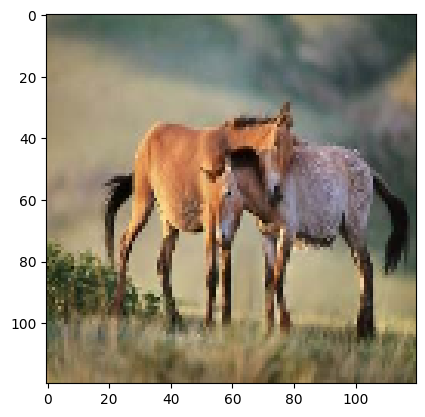

In [11]:
def reconstructed_image(img, non_converted_target_data):

    parts = divide_image(img)
    sequenced = [0] * 9
    for i, part in enumerate(parts):
        sequenced[non_converted_target_data[i]] = part

    stiched_img = stitch_shuffled_image(sequenced)
    return stiched_img

reconstructed_img = reconstructed_image(input_data[idx], non_converted_target_data[idx])
plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))

In [13]:
import torch.optim as optim


num_epochs = 10
batch_size = 64

In [14]:
# class JigsawDataset(Dataset):
#     def __init__(self, input_data, target_data, transform=None):
#         self.input_data = input_data
#         self.target_data = target_data
#         self.transform = transform

#     def __len__(self):
#         return len(self.input_data)

#     def __getitem__(self, idx):
#         image = self.input_data[idx]
#         target = self.target_data[idx]

#         if self.transform:
#             image = self.transform(image)

#         return image, target

In [15]:
# X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=0.2, random_state=42)

# train_dataset = JigsawDataset(X_train, y_train)
# test_dataset = JigsawDataset(X_test, y_test)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [16]:
class PieceDataset(Dataset):
    def __init__(self, pieces, transform=None):
        self.pieces = pieces
        self.transform = transform

    def __len__(self):
        return len(self.pieces)

    def __getitem__(self, idx):
        piece = self.pieces[idx]
        if self.transform:
            piece = self.transform(piece)
        return piece


In [17]:
pieces_data = []

for image in images:
    parts = divide_image(image)
    pieces_data.extend(parts)

pieces_data = np.array(pieces_data)


In [18]:
X_train, X_test = train_test_split(pieces_data, test_size=0.2, random_state=42)

train_dataset = PieceDataset(X_train)
test_dataset = PieceDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


In [19]:
from google.colab import files
src = list(files.upload().values())[0]
open('clip_model.py','wb').write(src)
import clip_model

Saving clip_model.py to clip_model (2).py


In [20]:
from clip_model import ModifiedResNet
model = ModifiedResNet(layers=[3, 4, 6, 3], output_dim=1000, heads=8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
model.train()  # Set the model to training mode

#feature_list = []
features_list = []

for epoch in range(num_epochs):
    running_loss = 0.0

#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data

#         inputs = inputs.permute(0, 3, 1, 2).float()


    for data in train_loader:
        inputs = data.float()
        inputs = inputs.permute(0, 3, 1, 2)  # Adjust depending on your model's expected input format

        # Assuming model has a method to return features
        #features = model.extract_features(inputs)

        features_list.append(inputs)


        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs,features = model(inputs,features_list)  # Adjust this if your model returns more than one output



        break
        # Compute the loss
        loss = criterion(outputs, labels.float())

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 100:.3f}')
            running_loss = 0.0
    break
print('Finished Training')

2048 tensor([[[[1.4707]],

         [[0.0288]],

         [[0.6282]],

         ...,

         [[0.6137]],

         [[1.5965]],

         [[1.0755]]],


        [[[0.0000]],

         [[0.7099]],

         [[1.9034]],

         ...,

         [[0.1069]],

         [[2.3576]],

         [[1.4856]]],


        [[[0.1626]],

         [[0.3495]],

         [[0.0000]],

         ...,

         [[0.3534]],

         [[0.0000]],

         [[0.8187]]],


        ...,


        [[[0.2703]],

         [[0.0000]],

         [[0.0000]],

         ...,

         [[0.0000]],

         [[0.9764]],

         [[2.1546]]],


        [[[0.0000]],

         [[0.5272]],

         [[0.6624]],

         ...,

         [[0.6620]],

         [[0.0000]],

         [[0.6116]]],


        [[[0.0062]],

         [[1.7793]],

         [[0.0000]],

         ...,

         [[0.4377]],

         [[0.7548]],

         [[0.0000]]]], grad_fn=<ReluBackward0>)
torch.Size([2, 64, 2048])
torch.Size([17, 1, 2048])


RuntimeError: The size of tensor a (2) must match the size of tensor b (17) at non-singleton dimension 0

In [22]:
features_list[0][0].shape


torch.Size([3, 40, 40])

In [23]:
print(len(features_list))

3


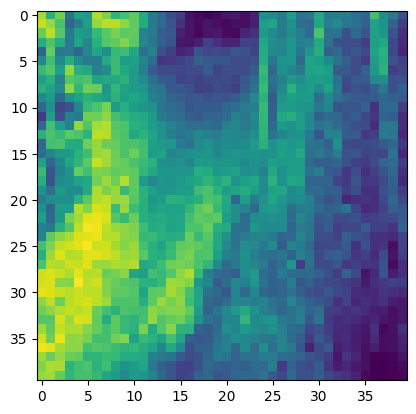

In [24]:
plt.imshow(features_list[0][0][0].detach().numpy())


In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from sklearn.model_selection import train_test_split

batch_size = 64
# Assuming the existence of 'images' list as in your prior code
# Create a custom dataset that returns shuffled image pieces and some target
class PuzzleDataset(Dataset):
    def __init__(self, input_data, target_data, transform=None):
        self.input_data = input_data
        self.target_data = target_data
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        image = self.input_data[idx]
        target = self.target_data[idx]

        if self.transform:
            image = self.transform(image)

        return image, target

X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=0.2, random_state=42)

train_dataset = PuzzleDataset(X_train, y_train)
test_dataset = PuzzleDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Load CLIP Model and Processor
model_name = 'openai/clip-vit-base-patch32'
clip_model = CLIPModel.from_pretrained(model_name)
clip_processor = CLIPProcessor.from_pretrained(model_name)
vision_model = clip_model.vision_model
for name, module in vision_model.named_children():
    if isinstance(module, nn.LayerNorm):
        # The layer normalization typically comes after the last encoder output
        vision_feature_dim = module.normalized_shape[0]
        print(f"Detected vision model feature dimension: {vision_feature_dim}")
        break

# Assuming num_labels is defined as the number of positions or classes
num_labels = 81  # for a 3x3 puzzle

# Add a new head to the CLIP model for classification
class ExtendedCLIPModel(nn.Module):
    def __init__(self, clip_model, feature_dim, num_labels):
        super().__init__()
        self.clip_model = clip_model
        self.classifier_head = nn.Linear(feature_dim, num_labels)

    def forward(self, pixel_values):
        # Pass through CLIP's vision model
        vision_output = self.clip_model.vision_model(pixel_values)
        # The output tuple's first element is the last hidden state
        last_hidden_state = vision_output.last_hidden_state
        # Pool the outputs into a single vector per example
        pooled_output = last_hidden_state[:, 0]
        # Pass the pooled output through the classifier head
        return self.classifier_head(pooled_output)

# Instantiate the extended model using the detected vision feature dimension
extended_model = ExtendedCLIPModel(clip_model, vision_feature_dim, num_labels)
# Define optimizer and loss function
optimizer = AdamW(extended_model.parameters(), lr=5e-5)
loss_fn = nn.BCEWithLogitsLoss()

num_epochs = 1  # Define the number of epochs

# Fine-tuning loop
extended_model.train()
for epoch in range(num_epochs):
    for batch in train_loader:
        # Assumes images are already in the form of a batch of PIL Images or tensors
        inputs = clip_processor(images=batch[0], return_tensors='pt')

        # Forward pass
        outputs = extended_model(inputs['pixel_values'])

        # Compute loss
        loss = loss_fn(outputs, batch[1].float())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Epoch {epoch}, Loss: {loss.item()}")

# Save the fine-tuned model
torch.save(extended_model.state_dict(), 'fine_tuned_clip_model.pth')


Detected vision model feature dimension: 768
Epoch 0, Loss: 0.6925942301750183
Epoch 0, Loss: 0.6270944476127625
Epoch 0, Loss: 0.5478628873825073
Epoch 0, Loss: 0.4933863580226898
Epoch 0, Loss: 0.4259277582168579
Epoch 0, Loss: 0.3811548352241516
Epoch 0, Loss: 0.3657873272895813
Epoch 0, Loss: 0.35567110776901245
Epoch 0, Loss: 0.35296371579170227
Epoch 0, Loss: 0.35434624552726746
Epoch 0, Loss: 0.35485783219337463
Epoch 0, Loss: 0.3571798503398895
Epoch 0, Loss: 0.35336655378341675


In [ ]:
extended_model.eval()

single_image = images[0]
single_image_parts = divide_image(single_image)

with torch.no_grad():
    whole_image_input = clip_processor(images=Image.fromarray(single_image), return_tensors='pt')
    whole_image_features = clip_model.get_image_features(**whole_image_input)

    print("Features for the whole image:")
    print(whole_image_features)

    for i, part in enumerate(single_image_parts):
        part_input = clip_processor(images=Image.fromarray(part), return_tensors='pt')
        part_features = clip_model.get_image_features(**part_input)

        print(f"Features for puzzle piece {i+1}:")
        print(part_features)


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss, Sigmoid

# Assuming `features` and `true_positions` are available
features_tensor = torch.stack(features)
true_positions_tensor = torch.tensor(true_positions, dtype=torch.float)  # one-hot encoded

# Create a dataset and dataloader
dataset = TensorDataset(features_tensor, true_positions_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Define the ANN classifier
class ANNClassifier(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_dim, 128)  # Example hidden layer
        self.fc2 = torch.nn.Linear(128, output_dim)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # BCEWithLogitsLoss includes the sigmoid activation
        return x

# Initialize the model
input_dim = features_tensor.shape[1]
output_dim = true_positions_tensor.shape[1]  # The number of puzzle positions
model = ANNClassifier(input_dim, output_dim)
optimizer = AdamW(model.parameters(), lr=1e-4)
loss_fn = BCEWithLogitsLoss()

# Training loop
model.train()
for epoch in range(num_epochs):
    for batch in dataloader:
        optimizer.zero_grad()
        inputs, targets = batch
        predictions = model(inputs)
        loss = loss_fn(predictions, targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}: loss {loss.item()}")

# Evaluation
model.eval()
with torch.no_grad():
    correct_piecewise, correct_overall, total_pieces = 0, 0, 0
    for batch in dataloader:
        inputs, targets = batch
        predictions = model(inputs)
        predicted_positions = torch.sigmoid(predictions) > 0.5  # Convert logits to probabilities
        correct_piecewise += (predicted_positions == targets).sum().item()
        correct_overall += (predicted_positions == targets).all(dim=1).sum().item()
        total_pieces += targets.numel()

piecewise_accuracy = correct_piecewise / total_pieces
overall_accuracy = correct_overall / len(dataset)

print(f"Piecewise accuracy: {piecewise_accuracy}")
print(f"Overall image reconstruction accuracy: {overall_accuracy}")
